<h1 align="center">Model selection</h1>

Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import PredefinedSplit
import pyarrow.parquet as pq
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix


<h2 style="text-align: left;">Understanding the problem</h2>


Download data

In [2]:
parquet_file_path = '/home/oscar/data/feature_frame.parquet'
data = pq.read_table(parquet_file_path).to_pandas()
data.shape

(2880549, 27)

In [4]:
order_ids = data['order_id'].unique()
porcentaje_muestra = 0.5  

cantidad_pedidos_muestra = int(len(order_ids) * porcentaje_muestra)

pedidos_muestra = np.random.choice(order_ids, size=cantidad_pedidos_muestra, replace=False)

data_muestreada = data[data['order_id'].isin(pedidos_muestra)]

print("Tamaño del conjunto de datos original:", data.shape)
print("Tamaño del conjunto de datos muestreado:", data_muestreada.shape)

Tamaño del conjunto de datos original: (1438257, 27)
Tamaño del conjunto de datos muestreado: (1440295, 27)


Firstly, we have to select those orders which contain at least 5 items, so we can filter the Data Frame owing to this specification. 

In [5]:
num_products_ordered = data.groupby('order_id')['outcome'].sum()
orders_with_5_or_more_unique_products = num_products_ordered[num_products_ordered>=5].index

filtered_data = data[data['order_id'].isin(orders_with_5_or_more_unique_products)]

print(f"Number of total orders: {data['order_id'].nunique()}")
print(f"Number of orders with more than 5 products: {filtered_data['order_id'].nunique()}")

Number of total orders: 1723
Number of orders with more than 5 products: 1324


<h2 style="text-align: left;">Feature Selection</h2>

In [6]:
target = ['outcome']
id_features = ['variant_id', 'order_id', 'user_id']
temporal_features = ['created_at', 'order_date']
binary_features = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
categorical_features = ['product_type', 'vendor'] 
non_numerical_features = target + id_features+ temporal_features + categorical_features

numerical_features = [feature for feature in filtered_data.columns if feature not in non_numerical_features]

**IDENTIFICATION FEATURES**

The identifying variables, order_id, user_id, and variant_id, serve to uniquely identify orders, users, and variants in the dataset. However, they do not possess any predictive power regarding the outcome of interest. Therefore, these identifying variables will not appear in the final dataset used for predictive modeling or analysis. 

In [7]:
features_to_remove = id_features

**TEMPORAL FEATURES**

In the "temporal_features" section, it's noted that the two temporal variables are of type "object." This observation is crucial because it highlights that these variables are stored as strings rather than datetime objects. It's essential to keep this in mind when reading the dataset to ensure proper conversion into the datetime format.

Converting these variables into the datetime format is important for several reasons, particularly when performing tasks such as time series analysis, feature engineering, or data splitting into training and testing sets.

In [8]:
filtered_data.loc[:,'order_date'] = pd.to_datetime(filtered_data.loc[:,'order_date'])
filtered_data.loc[:,'created_at'] = pd.to_datetime(filtered_data.loc[:,'created_at'])

There features represent essentially the same information, where 'order_date' and 'created_at' both capture temporal data. However, 'created_at' includes the time component in addition to the date, while 'order_date' only represents the date without the time.

In [9]:
features_to_remove.append('created_at')
print(features_to_remove)

['variant_id', 'order_id', 'user_id', 'created_at']


**BINARY FEATURES**

We initially considered aggregating these binary variables in some way, but it has been observed that they are not highly correlated with each other. Moreover, some individual variables, such as 'abandoned_before,' exhibit significant importance on their own for predicting the response variable.

In [10]:
print(filtered_data.groupby('abandoned_before')['outcome'].mean() * 100)

abandoned_before
0.0     1.413758
1.0    77.851459
Name: outcome, dtype: float64


When 'abandoned_before' is 0.0, indicating that the customer has not abandoned an order before, the mean purchase rate is approximately 1.39%. Conversely, when 'abandoned_before' is 1.0, indicating that the customer has previously abandoned an order, the mean purchase rate drastically increases to approximately 75.08%. This substantial difference in purchase rates suggests that the 'abandoned_before' variable holds considerable predictive power on its own in determining the likelihood of purchase.

In [11]:
print("Correlation Matrix between binary features:")
print(filtered_data[binary_features].corr())

Correlation Matrix between binary features:
                  ordered_before  abandoned_before  active_snoozed  \
ordered_before          1.000000          0.042620        0.258481   
abandoned_before        0.042620          1.000000        0.009137   
active_snoozed          0.258481          0.009137        1.000000   
set_as_regular          0.292770          0.032622        0.073649   

                  set_as_regular  
ordered_before          0.292770  
abandoned_before        0.032622  
active_snoozed          0.073649  
set_as_regular          1.000000  


**CATEGORICAL FEATURES**

The initial intention is to encode these variables by frequency. However, it's not feasible to perform this encoding directly on the initial dataset. Instead, it must be done separately for each split. This approach is necessary to prevent data leakage or contamination between the splits, which could lead to an overly optimistic estimation of model performance.

**NUMERICAL FEATURES**

The correlation matrices provide insights into linear relationships between variables, but it's important to note that non-linear relationships may exist, which are not captured by these matrices. Given this context, observing the correlation matrix provided, we can make several observations:

* The variables "avg_days_to_buy_variant_id" and "std_days_to_buy_variant_id" show moderate correlation with "days_since_purchase_variant_id."

* The variable "days_since_purchase_product_type" displays moderate correlation with "days_since_purchase_variant_id." 

* The variable "avg_days_to_buy_product_type" exhibits moderate correlation with "avg_days_to_buy_variant_id" and "std_days_to_buy_variant_id." 

Despite these observations, it's essential to remember that correlation matrices do not capture all relationships between variables, especially non-linear ones. Therefore, no variables will be eliminated at this point due to the possibility of non-linear relationships not reflected in these matrices.

In [12]:
print(filtered_data[[
    'days_since_purchase_variant_id',
    'avg_days_to_buy_variant_id',
    'std_days_to_buy_variant_id',
    'days_since_purchase_product_type',
    'avg_days_to_buy_product_type',
    'std_days_to_buy_product_type',
    'outcome'
]].corr())

                                  days_since_purchase_variant_id  \
days_since_purchase_variant_id                          1.000000   
avg_days_to_buy_variant_id                              0.024631   
std_days_to_buy_variant_id                              0.028232   
days_since_purchase_product_type                        0.211069   
avg_days_to_buy_product_type                            0.007735   
std_days_to_buy_product_type                            0.008522   
outcome                                                 0.031977   

                                  avg_days_to_buy_variant_id  \
days_since_purchase_variant_id                      0.024631   
avg_days_to_buy_variant_id                          1.000000   
std_days_to_buy_variant_id                          0.597947   
days_since_purchase_product_type                    0.001599   
avg_days_to_buy_product_type                        0.291157   
std_days_to_buy_product_type                        0.250001   
outcome

Variables related to family members were likely imputed mostly with the median, as observed in the exploratory data analysis (EDA). However, due to this imputation strategy, they may introduce more noise than information into the dataset. Therefore, they will not be used in the analysis.

In [13]:
features_to_remove.extend(['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby'])
print(features_to_remove)

['variant_id', 'order_id', 'user_id', 'created_at', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby']


**FINAL DATA**

In [14]:
final_data = filtered_data.drop(features_to_remove, axis=1)

<h2 style="text-align: left;">Getting training, validation and testing</h2>

**INITIAL SPLITTING**

In order to avoid information leakage, we must consider several key factors:
* We have to ensure that the same 'user_id' does not appear in both the training and testing datasets is crucial. This can lead to data leakage, compromisiing the integrity of the evaluation.
* It's essential to mantain the assumption that the training and testing datasets are independentrly and identically distributed to ensure the model's performance on the test data accurately reflexts its ability to generalize to unseen data

As we have **an imbalanced dataset**, we'll split the dataset into training and testing sets using **stratification**, and based on avoiding information leakage by user.

In [13]:
unique_users = data['user_id'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2)

In [14]:
train_data = data[data['user_id'].isin(train_users)]
test_data = data[data['user_id'].isin(test_users)]

In [15]:
X_train = train_data.drop('outcome', axis=1)
y_train = train_data['outcome']

X_test = test_data.drop('outcome', axis=1)
y_test = test_data['outcome']

In [16]:
print("Train set size:", len(train_data)/(len(train_data)+len(test_data)))
print("Test set size:", len(test_data)/(len(train_data)+len(test_data)))

Train set size: 0.7969782843478795
Test set size: 0.2030217156521205


Overall, the proportion of examples for each class is maintained well between the train and test sets. Despite the class imbalance, the proportion remains consistent across both sets. This suggests that stratifying the data during the train-test split may not be necessary in this case, as the imbalance is preserved in both sets without intervention. However, it's important to note that this imbalance might affect the performance of some classifiers, and strategies such as oversampling or undersampling of the minority class may be considered to address this issue.

In [17]:
train_class_percentages = train_data['outcome'].value_counts(normalize=True) * 100
test_class_percentages = test_data['outcome'].value_counts(normalize=True) * 100

print("Percentage of examples for each class in train set:")
print(train_class_percentages)
print("\nPercentage of examples for each class in test set:")
print(test_class_percentages)

Percentage of examples for each class in train set:
outcome
0.0    98.842506
1.0     1.157494
Name: proportion, dtype: float64

Percentage of examples for each class in test set:
outcome
0.0    98.861347
1.0     1.138653
Name: proportion, dtype: float64


The approach described above was a way to split the data without considering the temporal reference. Initially, I assumed that temporal information might not be crucial as there was already data available on the days since the last purchase, etc. However, upon further consideration, I realized the importance of incorporating temporal information into the data splitting process.

To address this, I devised another approach for splitting the data based on this temporal reference. This new approach involves dividing the dataset into training and testing sets while ensuring that the temporal sequence is preserved. By doing so, we aim to account for any temporal dependencies or patterns in the data, which may be critical for accurately modeling and predicting future outcomes.

**NEW SPLITTING**

When separating data, it's crucial to consider the date on which orders are placed for several reasons. Firstly, the temporal aspect provides valuable insights into patterns and trends over time, which can significantly impact the performance of predictive models. By incorporating temporal information into the data splitting process, we ensure that the training data represents past observations, while the testing or validation data represents future observations, mimicking real-world scenarios.

Moreover, not considering the date of orders can lead to a phenomenon known as data leakage. Data leakage occurs when information from the future or unseen data is inadvertently included in the training process, leading to overly optimistic performance estimates of the model. In the context of order data, if future information, such as orders placed after a certain date, is included in the training set, the model may learn patterns that do not generalize well to unseen data, resulting in poor model performance when deployed in production.

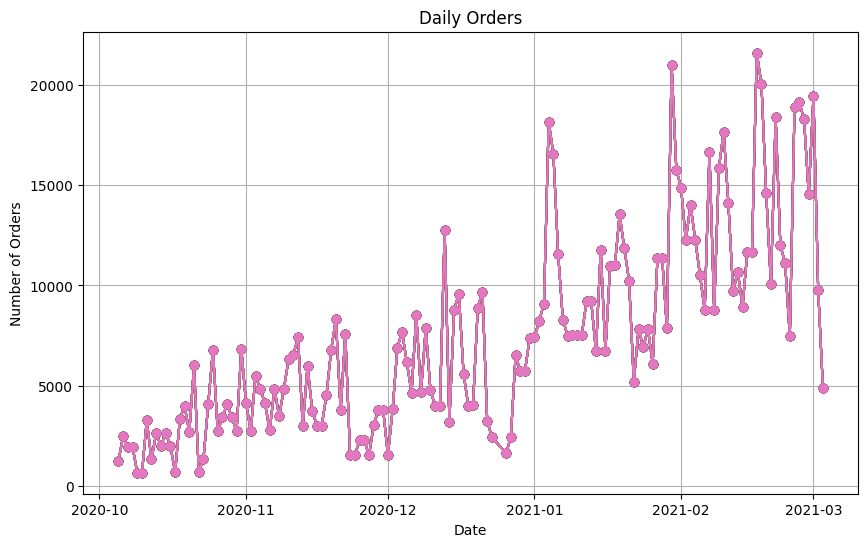

In [15]:
daily_orders = final_data.groupby('order_date').count()
plt.figure(figsize=(10, 6)) 
plt.plot(daily_orders, marker='o', linestyle='-')  
plt.title('Daily Orders')  
plt.xlabel('Date')  
plt.ylabel('Number of Orders')
plt.grid(True) 
plt.show()

Firstly, we should conduct research regarding date information:

In [16]:
print("Minimum order date:", final_data['order_date'].min())
print("Maximum order date:", final_data['order_date'].max())

Minimum order date: 2020-10-05 00:00:00
Maximum order date: 2021-03-03 00:00:00


The criterion followed for the separation is based on allocating 10 days for validation and 10 days for testing, while the remaining days are designated for training. This approach considers that there are more orders in the later dates, aiming to maintain a temporal relationship among the train-validation-test sets to prevent information contamination.

By adhering to this temporal relationship, we ensure that the data used for training comes from an earlier period than the data used for validation and testing. This prevents the model from learning patterns specific to the validation and testing data, thus promoting its ability to generalize to unseen data effectively. Additionally, allocating a larger portion of data to training ensures that the model learns from a diverse range of examples, enhancing its overall performance and robustness.

In [17]:
final_data_sorted = final_data.sort_values(by='order_date')

total_days = len(daily_orders)
validation_days = 10
testing_days = 10
training_days = total_days - validation_days - testing_days

train_start = daily_orders.index.min()
train_end = train_start + timedelta(days=training_days)

val_start = train_end
val_end = val_start + timedelta(days=validation_days)

test_start = val_end
test_end = test_start + timedelta(days=testing_days)

train_data = final_data_sorted[(final_data_sorted['order_date'] >= train_start) & (final_data_sorted['order_date'] < train_end)]
val_data = final_data_sorted[(final_data_sorted['order_date'] >= val_start) & (final_data_sorted['order_date'] < val_end)]
test_data = final_data_sorted[(final_data_sorted['order_date'] >= test_start) & (final_data_sorted['order_date'] < test_end)]


print("Training set size:", (len(train_data)/len(final_data_sorted)))
print("Validation set size:", (len(val_data)/len(final_data_sorted)))
print("Testing set size:", (len(test_data)/len(final_data_sorted)))

Training set size: 0.7226797503333678
Validation set size: 0.12802327844815198
Testing set size: 0.13598863365551317


**Possible issue**: What if I have a user who makes purchases in both the training and testing sets? Will the model learn from that user? Is there a risk of data leakage?

In [18]:
X_train = train_data.drop(columns=['outcome', 'order_date'])
y_train = train_data['outcome']

X_val = val_data.drop(columns=['outcome', 'order_date'])
y_val = val_data['outcome']

X_test = test_data.drop(columns=['outcome', 'order_date'])
y_test = test_data['outcome']

<h2 style="text-align: left;">Data training</h2>

In [19]:
score = metrics.make_scorer(metrics.average_precision_score, greater_is_better=True)

In [20]:
columns_to_encode = categorical_features

column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', ce.CountEncoder(min_group_size=1.0), columns_to_encode)
    ],
    remainder='passthrough' 
)

pipe = Pipeline([
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('reg', LogisticRegression(solver='newton-cg', C=1.0/1.0))
])


reg_values = np.geomspace(0.00001, 1e+4, num=10)
parameters = {'reg__C': 1.0/reg_values}

gridsearch = GridSearchCV(pipe, parameters,  
                          scoring=score, 
                          return_train_score=True)

gridsearch.fit(X_train, y_train)

: 

In [27]:
results = pd.DataFrame(gridsearch.cv_results_)
results = results[['param_reg__C', 'mean_train_score', 'mean_test_score']]
results.rename(columns={'param_reg__C': 'C'}, inplace=True)
results.sort_values(by='C', inplace=True)
print(results)

          C  mean_train_score  mean_test_score
9    0.0001          0.811186         0.821122
8     0.001          0.801535         0.814456
7      0.01          0.799664         0.813316
6       0.1          0.799456         0.813185
5       1.0          0.799434         0.813172
4      10.0          0.799432         0.813171
3     100.0          0.799432         0.813171
2    1000.0          0.799432         0.813171
1   10000.0          0.799432         0.813171
0  100000.0          0.799432         0.813171


In [28]:
mejor_estimador=gridsearch.best_estimator_
print('El mejor valor de lambda es:', 1/mejor_estimador['reg'].C)
print('El error en validación sería:',gridsearch.best_score_) 

El mejor valor de lambda es: 10000.0
El error en validación sería: 0.8211215190443564


In [ ]:
mejor_estimador=gridsearch.best_estimator_
print('El mejor valor de lambda es:', 1/mejor_estimador['reg'].C)
print('El error en validación sería:',gridsearch.best_score_) 

Now, let's examine the different data types present in our dataset. As we observed during the Exploratory Data Analysis (EDA), we identified two categorical variables that require special handling.

In [11]:
categorical_features = [column for column, dtype in X_train.dtypes.items() if dtype == 'object']
print(categorical_features)

['product_type', 'vendor']


Tt's crucial to note that when performing encoding, whether it's frequency encoding or target encoding, we cannot apply it to the entire dataset. Doing so would introduce bias in the validation data. Instead, it's essential to apply encoding separately to the training and validation datasets.

In [13]:
mejor_estimador=gridsearch.best_estimator_
print('El mejor valor de lambda es:', 1/mejor_estimador['reg'].C)
print('El error en validación sería:',gridsearch.best_score_) 

El mejor valor de lambda es: 10000.0
El error en validación sería: 0.9869201981069093


In [14]:
df = pd.DataFrame(gridsearch.cv_results_).sort_values('mean_test_score',ascending=False)
df[['params', 'mean_train_score', 'mean_test_score']].head(15)

,params,mean_train_score,mean_test_score
9,{'reg__C': 0.0001},0.989055,0.986920
8,{'reg__C': 0.001},0.989034,0.985979
7,{'reg__C': 0.01},0.989028,0.985876
6,{'reg__C': 0.1},0.989029,0.985863
0,{'reg__C': 99999.99999999999},0.989029,0.985862
1,{'reg__C': 10000.0},0.989029,0.985862
2,{'reg__C': 1000.0},0.989029,0.985862
3,{'reg__C': 100.0},0.989029,0.985862
4,{'reg__C': 10.0},0.989029,0.985862
5,{'reg__C': 1.0},0.989029,0.985862


In [16]:
import matplotlib.pyplot as plt
def plot_validation_curve(train_scores, test_scores, param_range, ax=None, param='Param', score='Score', scale=None):
    # Hacemos la media de los errores y sus desviaciones estándar
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    ax.set_title("Validation Curve")
    ax.set_xlabel(param)
    ax.set_ylabel(score)
        
    lw = 2
    if scale is None:
        plot_fun = ax.plot
    else:
        plot_fun = ax.semilogx
    plot_fun(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    ax.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plot_fun(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    ax.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    ax.legend(loc="best")
    
    return ax

In [ ]:
from sklearn.model_selection import validation_curve

param_range = np.geomspace(0.001, 1e+6, num=9)
train_scores, test_scores = validation_curve(
    pipe, X, y, param_name="reg__C", param_range=1/param_range, cv=KFold(n_splits=5, shuffle=True),
    scoring="neg_log_loss", n_jobs=1)

plot_validation_curve(train_scores, test_scores, param_range, param=r'$\lambda$', score=r'$J(\theta)$', scale='log')

In [29]:
from sklearn import metrics
def evalua_clasificador(clf, X, y):
    prediccion = clf.predict(X)
    # Calculamos las métricas que tienen en cuenta varias métricas individuales
    recall_medio = metrics.roc_auc_score(y, prediccion)*100
    cm = metrics.confusion_matrix(y, prediccion, labels=[1,0])
    recall = cm[0,0]/cm[0,:].sum()*100
    tnr = cm[1,1]/cm[1,:].sum()*100
    GM = (recall*tnr)**0.5
    fscore = metrics.f1_score(y, prediccion)*100
    print('El recall medio por clases es {:.2f}'.format(recall_medio))
    print('La media geométrica es {:.2f}'.format(GM))
    print('El Fscore es {:.2f}'.format(fscore))

In [30]:
evalua_clasificador(mejor_estimador, X_test, y_test)

El recall medio por clases es 52.47
La media geométrica es 22.30
El Fscore es 9.28


In [31]:
prediccion_test = mejor_estimador.predict(X_test)
accuracy_test = metrics.accuracy_score(y_test, prediccion_test)*100
print(accuracy_test)

cm_test = metrics.confusion_matrix(y_test, prediccion_test, labels=[1,0])
print(cm_test)

98.73205344140634
[[   199   3802]
 [    90 302862]]


In [24]:
prediccion_train = mejor_estimador.predict(X_train)
accuracy_train = metrics.accuracy_score(y_train, prediccion_train)*100
print(accuracy_train)

cm_train = metrics.confusion_matrix(y_train, prediccion_train, labels=[1,0])
print(cm_train)

98.89802977488598
[[   1634   24200]
 [    898 2250825]]


In [20]:
def muestra_ROC_courve(listaClfs, X, y, labels):
    # generamos una predicción sin calidad para la clase positiva (1): todas las predicciones con probabilidad 0
    ns_probs = [0 for _ in range(len(y))]
    # calculamos el área bajo la curva ROC (método roc_auc_score pasando las clases reales y las probabilidades de la clase positiva)
    ns_auc = metrics.roc_auc_score(y, ns_probs)*100.0
    # calculamos todos los pares de puntos (fpr, tpr) para dibujar la curva ROC (método roc_curve pasando las clases reales y las probabilidades de la clase positiva)
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y, ns_probs)
    
    # Para cada clasificador de la lista
    for i,clf in enumerate(listaClfs):
        # predecimos las probabilidades de predecir cada ejemplo en cada clase 
        if hasattr(clf, 'predict_proba'):
            # Si el clasificador implementa predict_proba nos quedamos con las predicciones de la clase positiva (1): segunda columna
            model_probs = clf.predict_proba(X)
            model_probs = model_probs[:, 1]
        else:
            # Si el clasificador implementa decision_function
            model_probs = clf.decision_function(X)


        # calculamos el área bajo la curva ROC (método roc_auc_score pasando las clases reales y las probabilidades de la clase positiva)
        model_auc = metrics.roc_auc_score(y, model_probs)*100.0
        # calculamos todos los pares de puntos (fpr, tpr) para dibujar la curva ROC (método roc_curve pasando las clases reales y las probabilidades de la clase positiva)
        model_fpr, model_tpr, _ = metrics.roc_curve(y, model_probs)
        # forma alternativa de calcular el área bajo la curva ROC: este valor tiene que ser igual al guardado en model_auc
            # auc vale para calcular el área bajo cualquier curva: en este caso es la ROC porque pasamos los puntos que la forman
        print('Área bajo la curva ROC de {}: {:.2f}'.format(labels[i],metrics.auc(model_fpr, model_tpr)*100))
        # Mostramos visualmente la curva ROC (plot mostrando fpr en el eje x y tpr en el eje y)
        plt.plot(model_fpr, model_tpr, label=labels[i])
        
    # mostramos la curva del modelo sin calidad
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin calidad')
    # Etiquetas de los ejes
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Leyenda
    plt.legend()
    # Título
    plt.title('Curvas ROC')
    # Mostramos la figura
    plt.show()

Área bajo la curva ROC de Regresión logística: 81.00


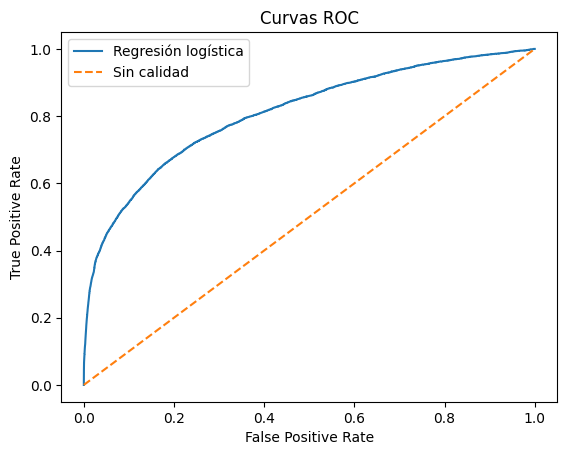

In [25]:
muestra_ROC_courve([mejor_estimador], X_test, y_test, labels=['Regresión logística'])

In [22]:
def muestra_PR_courve(listaClfs, X, y, labels):
    # Calculamos lo necesario para mostrar la curva PR y sus valores de rendimiento
    # Predicción sin calidad (proporción de ejemplos de la clase positiva, 1) 
    no_skill = len(y[y==1]) / len(y)
    
    # Para cada clasificador de la lista
    for i,clf in enumerate(listaClfs):
        
        # Predicciones de las clases de los datos
        predicciones = clf.predict(X)

        # predecimos las probabilidades de predecir cada ejemplo en cada clase 
        if hasattr(clf, 'predict_proba'):
            # Si el clasificador implementa predict_proba nos quedamos con las predicciones de la clase positiva (1): segunda columna
            model_probs = clf.predict_proba(X)
            model_probs = model_probs[:, 1]
        else:
            model_probs = clf.decision_function(X)

        # calculamos todos los pares de puntos (recall, precision) para dibujar la curva PR (método precision_recall_curve pasando las clases reales y las probabilidades de la clase positiva)
        model_precision, model_recall, thresholds = metrics.precision_recall_curve(y, model_probs) 
        # Calculamos el rendimientos f1-score (método f1_score pasando las clases reales y las predicciones del modelo)
        model_f1 = metrics.f1_score(y, predicciones)*100.0
        # Podemos calcular el área bajo la curva PR (uso del método auc: consultar celda de código anterior)
        model_auc_PR = metrics.auc(model_recall, model_precision)
        print('Área bajo la curva PR de {}: {:.2f}'.format(labels[i], model_auc_PR))

        # Mostramos visualmente la curva PR
        # mostramos el modelo
        plt.plot(model_recall, model_precision, label=labels[i])
    
    # Mostramos el modelo sin calidad
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin calidad')
    # Etiquetas de los ejes
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # Leyenda
    plt.legend()
    # Título
    plt.title('Curvas PR')
    # Mostramos la figura
    plt.show()

Área bajo la curva PR de Regresión logística: 0.16


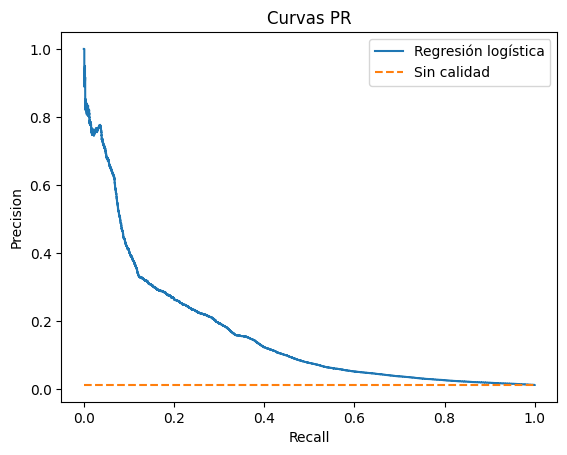

In [23]:
muestra_PR_courve([mejor_estimador], X_test, y_test, labels=['Regresión logística'])